# Practical session 3 - Brownian motion, Fourier transform

Students (pair):
- [Student 1]([link](https://github.com/username1)) MARTEL Alexandre
- [Student 2]([link](https://github.com/username2))

```
conda create --name=lab3 --file=requirement.txt
conda activate lab3
# do not forget to deactivate the environment if needed
# you can remove the environment once you are done
conda env remove --name=lab3
```

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## <a name="ex1">Exercise 1: Brownian motion</a>

This first exercise consists in generating a Brownian motion on the closed unit ball $\mathcal{B}(\mathbf{0}, 1) = \{ \mathbf{x} \mid \Vert \mathbf{x} \Vert  \leq 1\}$, focusing first on the 2-D case. The Brownian motion is a random walk with independent, identically distributed Gaussian increments, appearing for instance in thermodynamics and statistical mechanics (to model the evolution of a large particle in a medium composed of a large number of small particles, ...). It is also connected to the diffusion process (Einstein).

Let $N \in \mathbb{N}^*$, $\delta > 0$, and $\mathbf{x} = (x_1, x_2) \in  \mathcal{B}(\mathbf{0}, 1)$. The first $N$ steps of a 2-D discrete-time Brownian motion $W$ can be generated as follows

\begin{align*}
    W_0 &= \mathbf{x}, \\
    %
    (\forall n \in \{1, \dotsc, N-1 \}), \quad W_n &= W_{n−1} + \sqrt{\delta} G_n, \quad G_n \sim \mathcal{N}(\mathbf{0}, \mathbf{I}),
\end{align*}

where $\mathcal{N}(\mathbf{0}, \mathbf{I})$ is a Gaussian distribution with mean $\mathbf{0}$ and identity covariance matrix.

1. Define a random generator `rng`, set to a known state for reproducibility (see session 2).

**Answer:**

In [145]:
import numpy as np

# random generator with a fixed seed for reproducibility
seed = 42
rng = np.random.default_rng(seed)

rng.random()

0.7739560485559633

2. Implement a function `brownian_motion(niter, x, step, rng)` which

    - simulates $W$ until it reaches the boundary of $\mathcal{B}(\mathbf{0}, 1)$, using a maximum of $N$ iterations (`niter`), a starting point $\mathbf{x} \in \mathcal{B}(\mathbf{0}, 1)$ (`x`) and step-size $\delta$ (`step`);
    - interpolates linearly between the two last positions to determine the points $W^*$ where the trajectory crosses the boundary (if applicable);
    - returns both the whole random walk $W$ and, if appropriate, the point at the intersection between the last segment of the trajectory and $\mathcal{B}(\mathbf{0}, 1)$.
 
> Hint: 
> - you can easily derive a closed form expression for $W^*$, observing that $\Vert W^* \Vert^2= 1$ and $W^* \in [W_{n-1}, W_n]$. 
> - you can also take a look at [`np.roots`](https://numpy.org/doc/stable/reference/generated/numpy.roots.html?highlight=roots#numpy.roots) if needed.

> Recall of the Linear Interpolation (LERP) for $n$-dimensional vectors:
> - Clearly, $\vec{D}=\alpha \vec{C}$ with $\alpha \in [0, 1]$ and hence $\vec{P}-\vec{B}= \alpha (\vec{A}-\vec{B})$ which is equivalent to $\vec{P}= (1-\alpha) \vec{B} + \alpha \vec{A}$. 
![alternatvie text](img/for_Course.png)

**Answer:**

Intersection with the Unit Disk Boundary : 

We want to find the intersection point W\* where the trajectory crosses the boundary of the unit disk by linearly interpolating between the last two points.

For that we can write  $\vec{W^*}= (1-\alpha) \vec{W_n} + \alpha \vec{Wn-1}$ with $\alpha \in [0, 1]$ and we know that $\Vert W^* \Vert^2= 1$. Thus we have the following equation :
$\Vert (1-\alpha) {W_n} + \alpha {W_{n-1}} \Vert^2 = 1$ ie. $\Vert  {W_n} + \alpha({W_n}-{W_{n-1}})\Vert^2 = 1$ ie. we want to find the root of the following polynom : $({W_n}-{W_{n-1}})^2 \alpha ^2 + 2{W_n}({W_n}-{W_{n-1}})\alpha + ({W_n}) ^2 -1 = 0 $

In [126]:
def brownian_motion(niter, x, step, rng):

    """
    Simulate 2D Brownian motion inside the unit ball.

    Args :
        niter (int) : Maximum number of iterations
        x (tuple) : Initial position in the unit ball
        step (float) : Step size
        rng : Random number generator

    Returns :
    W (array) : Array of shape (m, 2) containing the trajectory points
    W_star (array or None) : Intersection point with the boundary if the trajectory crosses it, else None
    """

    x = np.array(x)
    # Check if the initial point is in the unit ball
    if np.linalg.norm(x) > 1.0 :
            raise ValueError("Initial point must be inside the unit ball !")

    W = [x] # add initial point to the path
    W_star = None

    for i in range(niter):

        G = rng.normal(0, 1, size=2) # Generate Gaussian increment
        w = W[i] + np.sqrt(step) * G # Brownian motion increment

        if np.linalg.norm(w) <= 1.0:
            # Still inside the ball
            W.append(w)
        else:
            # We crossed the boundary -> interpolation to find intersection W* ie. solve ||(1-alpha)B + alpha*A||^2 = 1 for alpha in [0,1]
            B = W[-1]
            A = w

            # Quadratic coefficients
            a = np.dot(A-B, A-B)
            b = 2 * np.dot(B, A-B)
            c = np.dot(B, B) - 1.0
            roots = np.roots([a, b, c])

            # Pick the root between 0 and 1
            alpha_candidates = roots[(roots >= 0) & (roots <= 1)]
            if alpha_candidates.size == 0:
                # Shouldn’t happen but safe fallback
                alpha = 1.0
            else:
                alpha = alpha_candidates[0]
            W_star = (1 - alpha) * B + alpha * A

            W.append(W_star)
            break

    return np.array(W), W_star


3. Diplay the trajectory of a Brownian motion starting from $\mathbf{x} = (0.2, 0.4)$, using $\delta = 10^{-2}$, $N = 1000$. Display the unit circle on the same figure, and highlight the intersection with the boundary of the domain (whenever it exists).

> Hint: to draw the unit disk, you can use for instance:
> ```python
> circle = plt.Circle((0,0), 1)
> fig, ax = plt.subplots()
> plt.xlim(-1.25,1.25)
> plt.ylim(-1.25,1.25)
> plt.grid(linestyle = "--", zorder = 1)
> ax.set_aspect(1)
> ax.add_artist(circle)
> ```

**Answer:**

In [81]:
import matplotlib.pyplot as plt

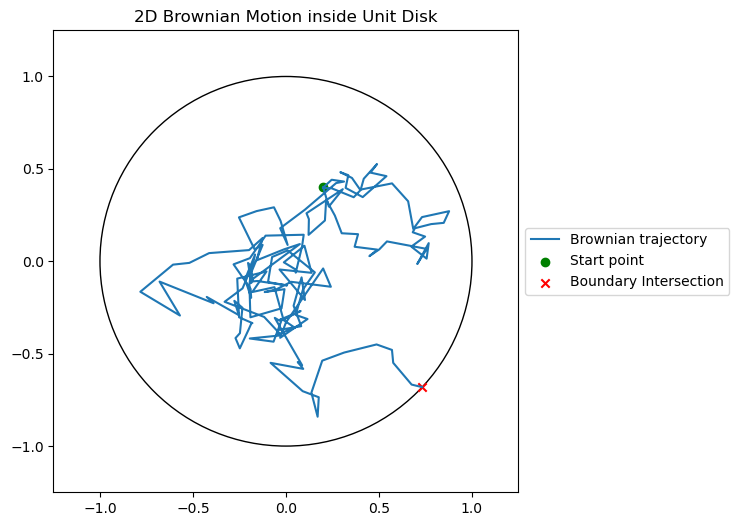

In [144]:
# Initialization
x0 = (0.2, 0.4)
delta = 1e-2
N = 1000
rng = np.random.default_rng(seed)

# Stimulate
W, W_star = brownian_motion(N, x0, delta, rng)

# Plot
circle = plt.Circle((0,0), 1, fill=False)  # unit circle
fig, ax = plt.subplots(figsize=(6,6))
plt.xlim(-1.25,1.25)
plt.ylim(-1.25,1.25)
plt.grid()
ax.add_artist(circle)

# Brownian trajectory
ax.plot(W[:,0], W[:,1], label='Brownian trajectory')
ax.scatter(W[0,0], W[0,1], color='green', label='Start point')

# Intersection point
if W_star is not None:
    ax.scatter(W_star[0], W_star[1], color='red',  marker='x', label='Boundary Intersection')

plt.legend()
plt.title("2D Brownian Motion inside Unit Disk")
plt.grid(False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # legend outside the plot
plt.show()

4. Represent, on the same figure, 4 other trajectories of $W$ with the same parameters.

**Answer:**

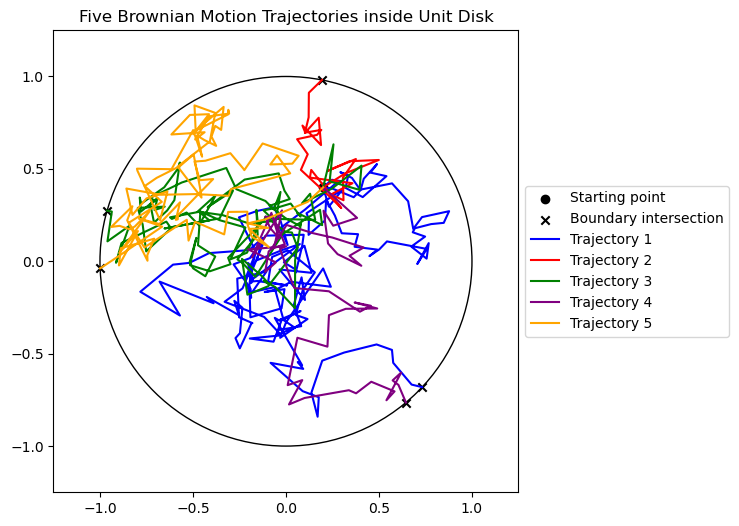

In [148]:
rng = np.random.default_rng(seed)

fig, ax = plt.subplots(figsize=(6,6))

# Draw unit circle
circle = plt.Circle((0,0), 1, fill=False)
ax.add_artist(circle)
plt.xlim(-1.25,1.25)
plt.ylim(-1.25,1.25)
plt.grid()

# Colors for different trajectories
colors = ['blue', 'red', 'green', 'purple', 'orange']

ax.scatter(x0[0], x0[1], color = 'black', marker = 'o', label = "Starting point")  # start point (same for all the trajectories)

x_marker_added = False  # flag to ensure label is only added once

for i in range(5):
    W, W_star = brownian_motion(N, x0, delta, rng)

    if W_star is not None:
        if not x_marker_added :
            ax.scatter(W_star[0], W_star[1], color='black', marker='x', label = "Boundary intersection")  # boundary intersection
            x_marker_added = True
        else :
            ax.scatter(W_star[0], W_star[1], color='black', marker='x')  # boundary intersection without label

    ax.plot(W[:,0], W[:,1], color=colors[i], label=f'Trajectory {i+1}')

plt.title("Five Brownian Motion Trajectories inside Unit Disk")
plt.grid(False)
plt.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # legend outside the plot
plt.show()


5. [Bonus] Generalize the procedure to a $M$-dimensional Brownian motion, $M > 2$.

**Answer:**

In [ ]:
def brownian_motion_M(niter, x, step, rng):

    """
    Simulate M-dimensional Brownian motion inside the unit ball.

    Args :
        niter (int) : Maximum number of iterations
        x (tuple) : Initial position in the unit ball
        step (float) : Step size
        rng : Random number generator

    Returns :
    W (array) : Array containing the trajectory points
    W_star (array or None) : Intersection point with the boundary if the trajectory crosses it, else None
    """


    x = np.array(x, dtype=float)
    M = x.shape[0]  # dimension
    if np.linalg.norm(x) > 1.0 :
        raise ValueError("Initial point must be inside the unit ball !")

    W = [x]
    W_star = None

    for i in range(niter):

        G = rng.normal(0, 1, size=M)   # Generate Gaussian increment in M dimensions
        w = W[-1] + np.sqrt(step) * G

        if np.linalg.norm(w) <= 1.0:
            # Still inside the ball
            W.append(w)
        else:
            # Iterpolation to find W* ie solve ||(1-alpha)B + alpha*A||^2 = 1 for alpha in [0,1]
            B = W[-1]
            A = w

            # Quadratic coefficients
            a = np.dot(A-B, A-B)
            b = 2 * np.dot(B, A-B)
            c = np.dot(B, B) - 1.0
            roots = np.roots([a, b, c])

            # Pick the root between 0 and 1
            alpha_candidates = roots[(roots >= 0) & (roots <= 1)]
            if alpha_candidates.size == 0:
                # Shouldn’t happen but safe fallback
                alpha = 1.0
            else:
                alpha = alpha_candidates[0]
            W_star = (1 - alpha) * B + alpha * A

            W.append(W_star)
            break

    return np.array(W), W_star


### 3D Visualization exemple

In [97]:
from mpl_toolkits.mplot3d import Axes3D

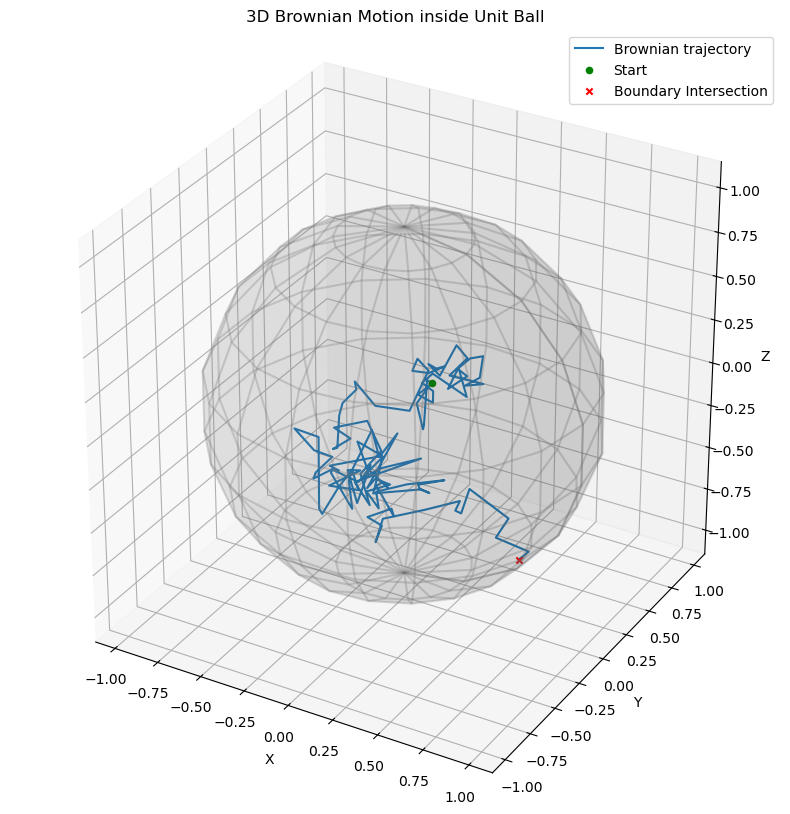

In [149]:
# Initialization
x0 = (0.1, 0.1, 0.1)
delta = 1e-2
N = 1000
rng = np.random.default_rng(seed)

# Simulate
W, W_star = brownian_motion_M(N, x0, delta, rng)

# Plot in 3D with transparent unit sphere
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='3d')
ax.set_aspect("equal")

# draw unit ball
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_wireframe(x, y, z, color="gray", alpha = 0.3)
ax.plot_surface(x, y, z, color='gray', alpha=0.1)

# Plot trajectory
ax.plot(W[:,0], W[:,1], W[:,2], label='Brownian trajectory')
ax.scatter(W[0,0], W[0,1], W[0,2], color='green', label='Start')

if W_star is not None:
    ax.scatter(W_star[0], W_star[1], W_star[2], color='red', marker = "x", label='Boundary Intersection')


# Axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Brownian Motion inside Unit Ball')
ax.legend()

plt.show()


---
## <a name="ex2">Exercise 2: 2D Fourier transform, ideal low-pass filter and linear convolution</a>

In this exercise, we explore the use of the 2-dimensional Fourier transform to filter an image, and convolve it with a blurring kernel.

1\. Load and display one of the images contained in the `img/` folder. The image will be denoted by $\mathbf{X} \in \mathbb{R}^{M_1 \times N_1}$ in the rest of this exercise.

**Answer:**

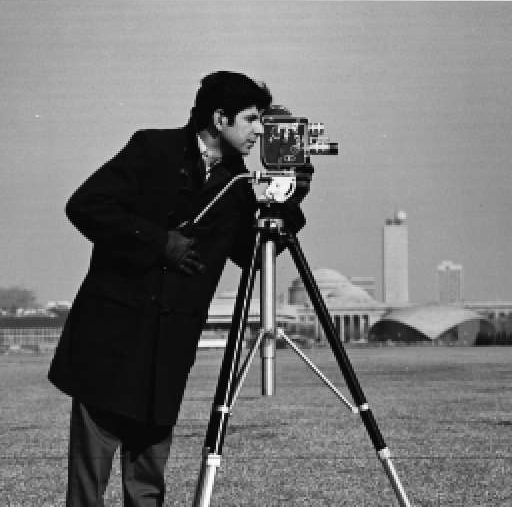

In [2]:
from PIL import Image

image = Image.open("img\cameraman.png")
image

2\. Let $\mathcal{F}$ denote the 2D discrete Fourier transform. Compute $|\mathcal{F}(\mathbf{X})|^2$, the spectrum of the image $\mathbf{X} \in \mathbb{R}^{M_1 \times N_1}$ (i.e., the term-wise squared absolute value of its Fourier transform) loaded in 1. Display the result in logarithmic scale.

a) In this representation, where is the pixel of the spectrum associated with the null frequency located?
    
b) Take a look at the documentation of `np.fft.fftshift`. Use it to ensure that the null frequency is located at the center of the image. 

**Answer:**

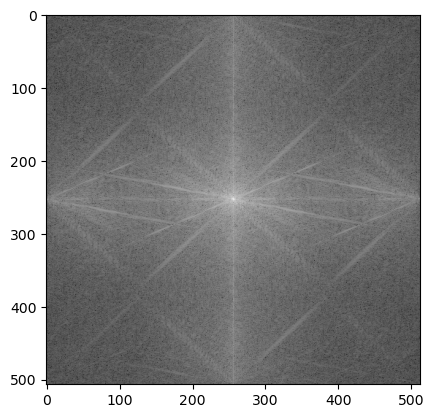

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

X = np.array(image)
F = np.fft.fft2(X)

#Pour le shift
F_shifted = np.fft.fftshift(F)
spectrum = np.abs(F_shifted)**2
plt.imshow(np.log(spectrum), cmap='gray')

# On a créé le spectre en amplitude d'une image et on l'a affiché en échelle log. Cela est cohérentpar rapport aux autres spectre d'image que l'on peut voir sur internet.


3\. 
    a) Create a function `ideal_lowpass_filter` to filter $\mathbf{X}$ by an ideal low-pass filter. The filter preserves Fourier coefficients associated to frequencies below a cutoff specified in each direction ($\mathbf{f}_c = (f_{c,y}, f_{c,x})$), and sets others to zero. For simplicity, $f_{c,y}$ and $f_{c,x}$ can be expressed as a number of samples to be kept along each dimension (e.g., $\mathbf{f}_c = (50,50)$).

b) Display the filtered image for 2 different values of $\mathbf{f}_c$. What do you observe as the cutoff frequencies increase?
    
> Warning: beware the type of the array after `np.fft.fft2`, do not hesitate to specify the type if you make copies from this array
> ```python
> a = np.zeros((2,2), dtype=np.complex)
> ...
> ```

**Answer:**

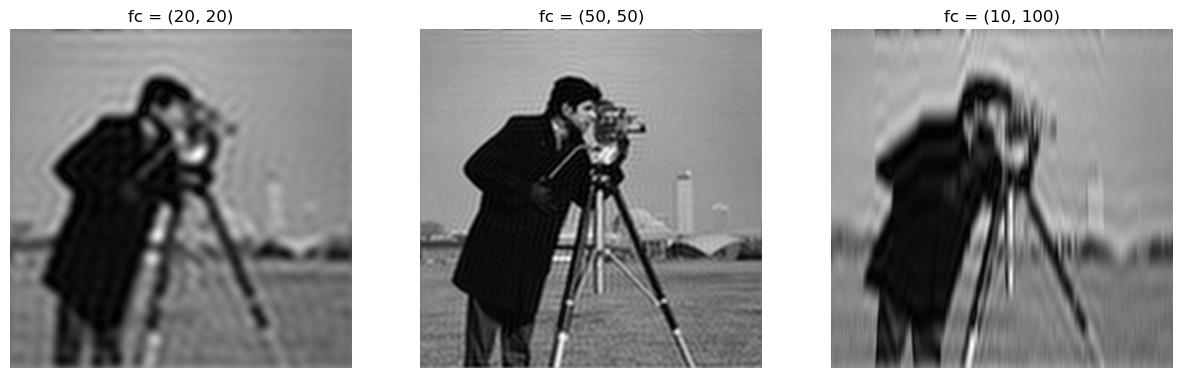

In [ ]:
import numpy as np

#On crée une fonction de filtrage passe-bas idéal
def ideal_lowpass_filter(X, fc):
    F = np.fft.fft2(X)
    F_shifted = np.fft.fftshift(F)
    h, w = X.shape
    cy, cx = h // 2, w // 2

    fy, fx = fc

    F_filtered = np.zeros_like(F_shifted,  dtype=complex)

    # Ceci est le masque du filtre passe-bas idéal, qui est une fenêtre rectangulaire centrée.
    F_filtered[cy-fy:cy+fy, cx-fx:cx+fx] = F_shifted[cy-fy:cy+fy, cx-fx:cx+fx]

    F_ishifted = np.fft.ifftshift(F_filtered)
    X_filtered = np.fft.ifft2(F_ishifted)

    return np.abs(X_filtered)

#exemples
X_filtered_20 = ideal_lowpass_filter(X, (20, 20))
X_filtered_50 = ideal_lowpass_filter(X, (50, 50))

# Je test des example un peu étranges pour observer le comportement
X_filtered_100 = ideal_lowpass_filter(X, (10, 100))

plt.figure(figsize=(15,5))


# On affiche en gris pour mieux visualiser
plt.imshow(X_filtered_20, cmap='gray')
plt.title('fc = (20, 20)')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(X_filtered_50, cmap='gray')
plt.title('fc = (50, 50)')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(X_filtered_100, cmap='gray')
plt.title('fc = (10, 100)')
plt.axis('off')

plt.show()


Réponse : Pour des valeurs de cutoff petites, seules les bassse fréquences sont conservées. Ce qui veut dire que l’image est très floue, et qu'on perd les détails.
En augmentant fc, plus de fréquences sont conservées donc l’image devient plus nette, jusqu’à retrouver environ l’originale si fc est grand.

4\. Let $\mathbf{H} \in \mathbb{R}^{M_2\times N_2}$ be a 2-D Gaussian kernel, obtained as the outer product of two 1-D Gaussian windows $\mathbf{w}_y \in \mathbb{R}^{M_2}$ and $\mathbf{w}_x \in \mathbb{R}^{N_2}$, of standard deviation $\sigma_y = 10$ and $\sigma_x = 10$, respectively:

\begin{equation}
    \mathbf{H} = \mathbf{w}_y \mathbf{w}_x^T.
\end{equation}

Let $M = M_1+M_2-1$ and $N =  N_1+N_2-1$. From the discrete convolution theorem, the linear convolution between $\mathbf{H}$ and $\mathbf{X}$ can be computed as follows

\begin{equation}
    \mathbf{X} \star \mathbf{H} = \mathcal{F}^{-1} \Big( \mathcal{F}\big(P_1(\mathbf{X})\big) \odot \mathcal{F}\big(P_2(\mathbf{H})\big) \Big) \in \mathbb{R}^{M\times N},
\end{equation}

where $P_i: \mathbb{R}^{M_i \times N_i} \rightarrow \mathbb{R}^{M \times N}$, $i \in \{1, 2\}$, are 0-padding operators, $\odot$ is the Hadamard (= term-wise) product, $\mathcal{F}^{-1}$ is the 2D discrete inverse Fourier transform.

Compute and display $\mathbf{X} \star \mathbf{H}$, for $M_2 = N_2 = 10$. What do you observe?

> Hint: 
> - the usual 0-padding procedure in image space consists in appending trailing zeros. For instance (in 1D), 0-padding a vector $\mathbf{x} \in \mathbb{R}^N_1$ to the size $N>N_1$ corresponds to creating the vector
\begin{bmatrix}
\mathbf{x} \\
\mathbf{0}_{N-N_1}
\end{bmatrix}
> - since the input images are real, $\mathcal{F}(\mathbf{x})$ and $\mathcal{F}(\mathbf{h})$ are Hermitian symmetric. In this case, a more efficient version of `np.fft.fft2` can be used, computing only quarter of the Fourier coefficients (half of the Fourier coefficients in each direction): [`np.fft.rfft2`](https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft2.html?highlight=rfft#numpy.fft.rfft2). Its inverse, [`np.fft.irfft2`](https://numpy.org/doc/stable/reference/generated/numpy.fft.irfft2.html#numpy.fft.irfft2), also ensures that the output is real;
> - the 2D Gaussian window can be generated as the outer product of two 1D Gaussian windows (one window for each dimension);
> - you can take a look at [scipy.signal.windows.gaussian](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.gaussian.html#scipy.signal.windows.gaussian) and [np.newaxis](https://numpy.org/doc/stable/reference/constants.html?highlight=newaxis#numpy.newaxis) (or `np.reshape` or built-in `np.outer`).

**Answer:**

In [ ]:
from scipy.signal.windows import gaussian
import numpy as np

M2, N2 = 10, 10
sigma_y, sigma_x = 10, 10

# On créer un Gaussian kernel 2D en multipliant deux gaussiens 1D

wy = gaussian(M2, std=sigma_y)[:, np.newaxis]  # vecteur colonne
wx = gaussian(N2, std=sigma_x)[np.newaxis, :]  # vecteur ligne

H = wy @ wx  #H -> (M2, N2)

In [7]:
M1, N1 = X.shape
M = M1 + M2 - 1
N = N1 + N2 - 1

X_pad = np.zeros((M, N))
H_pad = np.zeros((M, N))

X_pad[:M1, :N1] = X
H_pad[:M2, :N2] = H


In [ ]:
F_X = np.fft.fft2(X_pad)
F_H = np.fft.fft2(H_pad)

# On a créé les versions avec padding de X et H, puis on a calculé leur transformée de Fourier 2D.

# frequence produit
F_conv = F_X * F_H

X_conv = np.fft.ifft2(F_conv).real


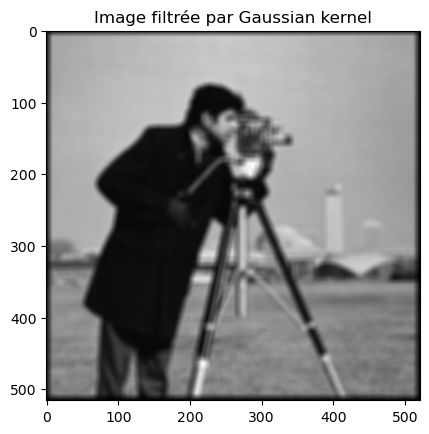

In [21]:
import matplotlib.pyplot as plt
plt.imshow(X_conv, cmap='gray')
plt.title("Image filtrée par Gaussian kernel")
plt.show()
